In [ ]:
!pip install higher

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets,transforms
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import itertools
from torch.utils.data import DataLoader
import time
import copy
import torch.nn.functional as F
from torch import autograd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from higher import innerloop_ctx as metaloop

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

mnist_train = datasets.MNIST(root='./data', train=True, download=True)
mnist_test = datasets.MNIST(root='./data', train=False, download=True)


class CustomDataset(Dataset):
    '''returns an imbalanced mnist dataset depending on class_ratios and noise_ratios that you enter '''
    def __init__(self, X, y, class_ratios, noise_ratios):
        self.X = np.copy(X)
        self.y = np.copy(y)
        N = len(X)

        #  get unique labels and their count in the dataset
        self.unique_y, self.y_counts = np.unique(self.y, return_counts=True)
        assert len(class_ratios) == len(self.unique_y)
        assert len(noise_ratios) == len(self.unique_y)
        print(f"Unique labels input {self.unique_y}, Count {self.y_counts}")

        # normalize class ratio list
        self.class_ratios = class_ratios

        # prune dataset
        for label in self.unique_y:
          idx = np.where(self.y == label)[0]
          n_samples = min(len(idx),int(self.class_ratios[label] * len(idx)))
          to_remove = np.random.choice(idx, len(idx) - n_samples, replace=False)
          self.y[to_remove] = -10000
        self.X = self.X[self.y!=-10000]
        self.y = self.y[self.y!=-10000]

        self.unique_y, self.y_counts = np.unique(self.y, return_counts=True)
        print(f"Unique labels after pruning {self.unique_y}, Count {self.y_counts}")

        # add noise to each class
        self.noise_ratios = noise_ratios
        for label in self.unique_y:
          idx = np.where(self.y == label)[0]
          n_noise = min(len(idx),int(self.noise_ratios[label] * N))
          to_noise = np.random.choice(idx, n_noise, replace=False)
          self.y[to_noise] = np.random.choice(self.unique_y, n_noise, replace=True)

        self.N_classes = len(self.unique_y)


    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image, label = self.X[idx], self.y[idx]


        onehot_label = np.where(self.unique_y == label)[0][0]
        onehot_label = torch.tensor(onehot_label, dtype=torch.float32)

        image = torch.tensor(image, dtype=torch.float32)/255.0
        image = image.unsqueeze(0)

        # image= self.transform(image)

        return image, onehot_label


batch_size = 64
labels = mnist_train.targets.numpy()
data = mnist_train.data.numpy()
test_data = mnist_test.data.numpy()
test_labels =  mnist_test.targets.numpy()
class_ratios = {0:0.1, 1:0.1, 2:0.1, 3:0.1, 4:0.1, 5:0.1, 6:0.1, 7:0.1, 8:1, 9:0.1}
noise_ratios = {0:0.25, 1:0.25, 2:0.25, 3:0.25, 4:0.25, 5:0.25, 6:0.25, 7:0.25, 8:0.25, 9:0.25}  # noise ratio should be < 1 for each class. If no noise 0

class_ratios_test = {0:0.5, 1:0.5, 2:0.5, 3:0.5, 4:0.5, 5:0.5, 6:0.5, 7:0.5, 8:0.5, 9:0.5}
noise_ratios_test = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}  # noise ratio should be < 1 for each class. If no noise 0
train_loader = DataLoader(CustomDataset(data, labels, class_ratios,noise_ratios), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(CustomDataset(test_data, test_labels, class_ratios_test,noise_ratios_test), batch_size=batch_size, shuffle=False)

val_loader = DataLoader(CustomDataset(test_data, test_labels, class_ratios_test,noise_ratios_test), batch_size=batch_size, shuffle=True)


Unique labels input [0 1 2 3 4 5 6 7 8 9], Count [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]
Unique labels after pruning [0 1 2 3 4 5 6 7 8 9], Count [ 592  674  595  613  584  542  591  626 5851  594]
Unique labels input [0 1 2 3 4 5 6 7 8 9], Count [ 980 1135 1032 1010  982  892  958 1028  974 1009]
Unique labels after pruning [0 1 2 3 4 5 6 7 8 9], Count [490 567 516 505 491 446 479 514 487 504]
Unique labels input [0 1 2 3 4 5 6 7 8 9], Count [ 980 1135 1032 1010  982  892  958 1028  974 1009]
Unique labels after pruning [0 1 2 3 4 5 6 7 8 9], Count [490 567 516 505 491 446 479 514 487 504]


torch.Size([64, 1, 28, 28]) torch.Size([64])
tensor(1.)


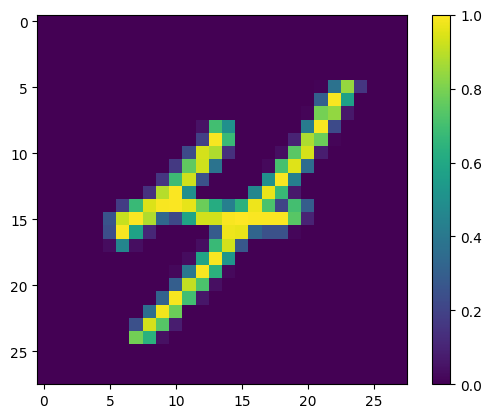

In [ ]:
for data, label in train_loader:
  break
print(data.shape, label.shape)

plt.imshow(data[1,0])
plt.colorbar()
print(label[1])

In [ ]:
# Collect 100 samples of the selected classes from test dataset as validation data
X_validation = []
y_validation = []

for sample in val_loader:
    X_validation.append(sample[0])
    y_validation.append(sample[1])

X_validation = torch.vstack(X_validation)[:100]
y_validation = torch.hstack(y_validation)[:100]
print(X_validation.shape)
print(y_validation.shape)


torch.Size([100, 1, 28, 28])
torch.Size([100])


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, n_out):
        super(SimpleCNN, self).__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        # fully connected layers
        self.fc1 = nn.Linear(128 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, n_out)

        #max pooling layers
        self.maxpool= nn.MaxPool2d(2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool(x)
        x = x.view(-1, 128 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x).squeeze()
        return x

In [ ]:
class trainer():
    def __init__(self, model, train_dataloader, test_dataloader, X_validation, y_validation, device):
        self.device= device
        self.model= model.to(device)
        self.train_dataloader= train_dataloader
        self.test_dataloader= test_dataloader
        self.X_val= X_validation
        self.y_val= y_validation


    def train_normal(self, epochs):
        '''trains the model using traditional approach'''
        criterion= torch.nn.CrossEntropyLoss().to(self.device)
        # criterion= torch.nn.BCEWithLogitsLoss().to(device)
        optimizer= torch.optim.Adam(self.model.parameters(), lr=0.001)
        running_loss_per_epoch=[]
        test_stats=[]
        for epoch in range(epochs):
            self.model.train()
            total_num=0
            running_loss= 0
            train_acc=0
            running_loss_per_batch= []
            for i, data in enumerate(self.train_dataloader):
                images, labels= data
                images= images.to(self.device)
                labels= labels.to(self.device)

                predicted_logits= self.model(images)
                # pred_labels= (F.sigmoid(predicted_logits)>0.5).int()
                # print(predicted_logits.shape)
                pred_labels= torch.argmax(predicted_logits, axis=1)
                # loss= criterion(predicted_logits, labels.type_as(predicted_logits))
                loss= criterion(predicted_logits, labels.long())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                train_acc += torch.sum(torch.eq(pred_labels, labels)).item()
                running_loss_per_batch.append(loss.item())
                total_num+= len(images)

            running_loss_per_epoch.append(np.mean(running_loss_per_batch))
            print("[epoch: %d] loss: %.3f    train accuracy: %.3f" \
                    % (epoch + 1,  running_loss_per_epoch[-1], (train_acc/total_num)*100))
            test_stat= self.test()
            test_stats.append(test_stat['accuracy'])

        return test_stats


    def test(self):
        # criterion= torch.nn.BCEWithLogitsLoss().to(device)
        criterion= torch.nn.CrossEntropyLoss().to(self.device)
        self.model.eval()  #setting the model in evaluation mode
        val_stat={}
        all_accuracy=[]
        all_loss=[]
        all_predictions=[]
        all_labels=[]
        total_num=0
        with torch.no_grad():
            running_loss_per_batch=[]
            for images, labels in self.test_dataloader:
                images, labels= images.to(device), labels.to(device)
                predicted_logits = self.model(images).float()
                labels_tensor = labels.clone().detach()
                # pred_labels= (F.sigmoid(pred_logits)>0.5).int()
                pred_labels= torch.argmax(predicted_logits, axis=1)
                # loss=criterion(pred_logits, labels_tensor.type_as(pred_logits))
                loss= criterion(predicted_logits, labels.long())
                accuracy= torch.sum(torch.eq(pred_labels, labels)).item()
                running_loss_per_batch.append(loss.item())    #tracking the loss, accuracy, predicted labels, and true labels
                all_accuracy.append(accuracy)
                all_predictions.append(pred_labels)
                all_labels.append(labels)
                total_num+=len(images)

        val_stat['loss'] = np.mean(running_loss_per_batch)
        val_stat['accuracy']=sum(all_accuracy)/total_num
        val_stat['prediction']=torch.cat(all_predictions, dim=0)
        val_stat['labels']=torch.cat(all_labels, dim=0)
        print(f"Test/Validation result: total sample: {total_num}, Avg loss: {val_stat['loss']:.3f}, Acc: {100*val_stat['accuracy']:.3f}%")
        return val_stat #returning the tracked values in the form of a dictionary



    def train_reweighted(self, epochs):
        '''trains the model using reweighted sampling approach'''
        # criterion = torch.nn.BCEWithLogitsLoss().to(self.device)
        criterion= torch.nn.CrossEntropyLoss().to(self.device)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        running_loss_per_epoch = []
        test_stats=[]
        for epoch in range(epochs):
            self.model.train()
            train_acc = 0
            total_num = 0
            running_loss = 0
            running_loss_per_batch = []

            for i, data in enumerate(self.train_dataloader):
                # L2-L3: get data
                images, labels = data
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                # Inner loop for reweighted training
                with metaloop(self.model, optimizer) as (inner_model, inner_optimizer):
                    # L4-L5: 1. forward pass to compute the initial weighted loss
                    inner_train_outputs = inner_model(images)
                    # cost = criterion(inner_train_outputs, labels.type_as(inner_train_outputs))
                    cost = criterion(inner_train_outputs, labels.long())
                    eps = torch.zeros(cost.size(), requires_grad=True, device=self.device)  # sample weights
                    inner_trainloss = torch.sum(eps * cost)
                    # L6-L7: model parameter update
                    inner_optimizer.step(inner_trainloss)

                    # L8-L10: computes validation loss and gradients for reweighting
                    # _criterion = torch.nn.BCEWithLogitsLoss(reduction= 'mean').to(self.device)
                    _criterion = torch.nn.CrossEntropyLoss(reduction= 'mean').to(self.device)
                    val_loss = 0
                    val_images, val_labels = self.X_val.to(device=self.device), self.y_val.to(device=self.device)
                    val_pred_logits = inner_model(val_images)
                    loss = _criterion(val_pred_logits, val_labels.long())
                    eps_grads= (torch.autograd.grad(loss, eps, allow_unused=True)[0].detach())

                # L11: Compute weights for reweighting based on validation gradients
                w_tilde = torch.clamp(-eps_grads, min=0)
                norm = torch.sum(w_tilde)
                w = w_tilde / norm if norm != 0 else w_tilde

                # L12-L14: Perform standard training step using reweighted loss
                predicted_logits = self.model(images)
                # pred_labels = (F.sigmoid(predicted_logits) > 0.5).int()
                pred_labels= torch.argmax(predicted_logits, axis=1)
                criterion.reduction= 'none'
                # loss = criterion(predicted_logits, labels.type_as(predicted_logits))
                loss= criterion(predicted_logits, labels.long())
                loss = torch.sum(w * loss)

                # Update variables
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                train_acc += torch.sum(torch.eq(pred_labels, labels)).item()
                running_loss_per_batch.append(loss.item())
                total_num += len(images)

            running_loss_per_epoch.append(np.mean(running_loss_per_batch))
            print("[epoch: %d] loss: %.3f    train accuracy: %.3f" % (epoch + 1, running_loss_per_epoch[-1], (train_acc / total_num) * 100))

            test_stat= self.test()
            test_stats.append(test_stat['accuracy'])

        return test_stats

In [ ]:
# Instantiate and train model using traditional method
model = SimpleCNN(n_out=10)
my_trainer_normal= trainer(model, train_loader, test_loader, X_validation, y_validation, device)
normal_acc=my_trainer_normal.train_normal(epochs= 20)


[epoch: 1] loss: 2.244    train accuracy: 12.928
Test/Validation result: total sample: 4999, Avg loss: 2.396, Acc: 9.802%
[epoch: 2] loss: 2.237    train accuracy: 13.248
Test/Validation result: total sample: 4999, Avg loss: 2.323, Acc: 9.802%
[epoch: 3] loss: 2.222    train accuracy: 13.470
Test/Validation result: total sample: 4999, Avg loss: 2.211, Acc: 11.342%
[epoch: 4] loss: 2.208    train accuracy: 14.012
Test/Validation result: total sample: 4999, Avg loss: 2.161, Acc: 13.903%
[epoch: 5] loss: 2.201    train accuracy: 14.118
Test/Validation result: total sample: 4999, Avg loss: 2.170, Acc: 14.723%
[epoch: 6] loss: 2.195    train accuracy: 14.953
Test/Validation result: total sample: 4999, Avg loss: 2.118, Acc: 27.465%
[epoch: 7] loss: 2.188    train accuracy: 15.326
Test/Validation result: total sample: 4999, Avg loss: 2.077, Acc: 25.405%
[epoch: 8] loss: 2.179    train accuracy: 15.832
Test/Validation result: total sample: 4999, Avg loss: 2.106, Acc: 24.305%
[epoch: 9] loss: 2

In [ ]:
# Instantiate and train model using proposed method
model2= SimpleCNN(n_out=10)
my_trainer2= trainer(model2, train_loader, test_loader, X_validation, y_validation, device)
reweighted_acc=my_trainer2.train_reweighted(epochs= 20)

[epoch: 1] loss: 2.237    train accuracy: 10.664
Test/Validation result: total sample: 4999, Avg loss: 2.098, Acc: 20.664%
[epoch: 2] loss: 2.031    train accuracy: 12.742
Test/Validation result: total sample: 4999, Avg loss: 1.960, Acc: 28.646%
[epoch: 3] loss: 1.884    train accuracy: 12.600
Test/Validation result: total sample: 4999, Avg loss: 1.639, Acc: 37.628%
[epoch: 4] loss: 1.708    train accuracy: 13.914
Test/Validation result: total sample: 4999, Avg loss: 1.409, Acc: 44.469%
[epoch: 5] loss: 1.585    train accuracy: 13.248
Test/Validation result: total sample: 4999, Avg loss: 1.383, Acc: 47.289%
[epoch: 6] loss: 1.481    train accuracy: 13.195
Test/Validation result: total sample: 4999, Avg loss: 1.323, Acc: 50.330%
[epoch: 7] loss: 1.447    train accuracy: 13.639
Test/Validation result: total sample: 4999, Avg loss: 1.261, Acc: 52.470%
[epoch: 8] loss: 1.400    train accuracy: 13.443
Test/Validation result: total sample: 4999, Avg loss: 1.291, Acc: 52.871%
[epoch: 9] loss:

In [ ]:
def plot_conf_matrix(conf_matrix, class_names):
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = conf_matrix.max() / 2.0
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, f'{conf_matrix[i, j]}', horizontalalignment="center", color="white" if conf_matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
class_names= ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [ ]:
test_stat_simple= my_trainer_normal.test()

Test/Validation result: total sample: 4999, Avg loss: 4.140, Acc: 16.563%


In [ ]:
test_stat_reweighed= my_trainer2.test()

Test/Validation result: total sample: 4999, Avg loss: 0.820, Acc: 73.555%


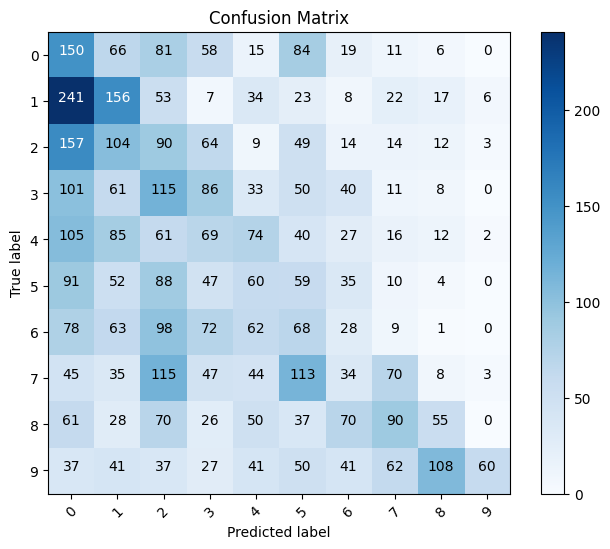

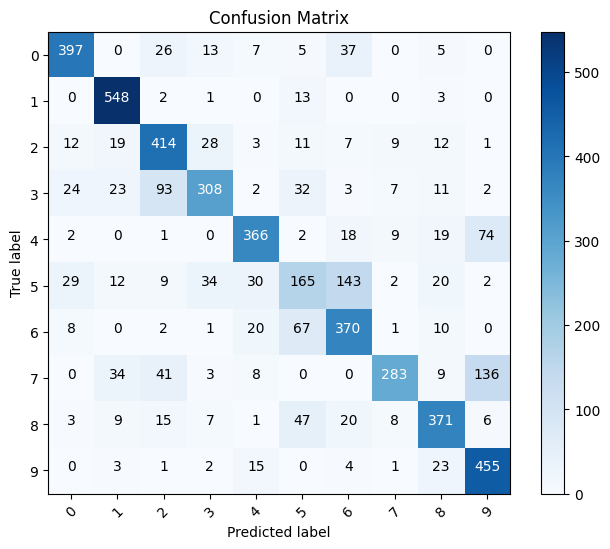

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix_simple= confusion_matrix(test_stat_simple['labels'].cpu(), test_stat_simple['prediction'].cpu())
plot_conf_matrix(conf_matrix_simple, class_names)
conf_matrix_reweighed= confusion_matrix(test_stat_reweighed['labels'].cpu(), test_stat_reweighed['prediction'].cpu())
plot_conf_matrix(conf_matrix_reweighed, class_names)

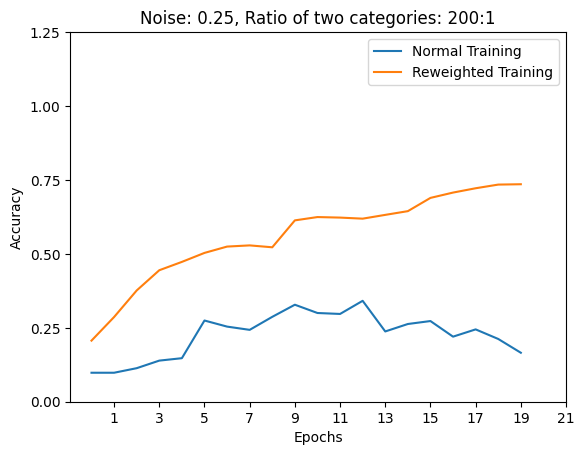

In [ ]:
fig, ax = plt.subplots(1)
ax.plot(normal_acc, label='Normal Training')
ax.plot(reweighted_acc, label='Reweighted Training')
ax.set_xlabel('Epochs')
ax.set_xticks(np.array([1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]))
ax.set_yticks([0, 0.25, 0.5, 0.75, 1, 1.25])
ax.set_ylabel('Accuracy')
plt.title('Noise: 0.25, Ratio of two categories: 200:1')
plt.legend()
plt.show()